In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# cd into working directory
%cd /content/drive/My\ Drive/AML_Assignment2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AML_Assignment2


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import random
import copy
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
# check gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def seed_torch(seed=42):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # if multi-GPUs are used
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
def train_val_split(features, labels, training_pct=0.8):

    assert features.shape[0] == labels.shape[0]
    assert training_pct > 0

    n = features.shape[0]
    indices = list(range(n))
    random.shuffle(indices)

    split_idx = int(training_pct * n)
    Xtr = features[indices[0:split_idx]]
    Str = labels[indices[0:split_idx]]
    Xval = features[indices[split_idx:]]
    Sval = labels[indices[split_idx:]]

    return Xtr, Str, Xval, Sval

In [ ]:
class DatasetArray(Dataset):

    def __init__(self, features, labels):

        self.features = torch.unsqueeze(torch.from_numpy(features.astype(np.float32) / 255), 1)
        self.labels = labels.astype(np.int64)
                
    def __len__(self):
            
        return len(self.labels)
        
    def __getitem__(self, index):
         
        features = self.features[index]
        labels = self.labels[index]
                        
        return (features, labels)

In [ ]:
def get_loader(data_path, training_pct=0.8, batch_size=[100, 100, 100], num_workers=1):

    dataset = np.load(data_path)
    x_tr_val = dataset['Xtr']
    s_tr_val = dataset['Str']
    x_ts = dataset['Xts']
    y_ts = dataset['Yts']
        
    x_tr, s_tr, x_val, s_val = train_val_split(x_tr_val, s_tr_val, training_pct=training_pct)

    training_dataset = DatasetArray(x_tr, s_tr)
    validation_dataset = DatasetArray(x_val, s_val)
    test_dataset = DatasetArray(x_ts, y_ts)

    training_dataloader = DataLoader(training_dataset, batch_size=batch_size[0], shuffle=True, num_workers=num_workers)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size[1], shuffle=False, num_workers=num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size[2], shuffle=False, num_workers=num_workers)

    return training_dataloader, validation_dataloader, test_dataloader

In [ ]:
class CNNmodel(torch.nn.Module):

    def __init__(self, input_channels=1, hidden1_dim=160, hidden2_dim=22, output_dim=3, transition_matrix=None):

        super(CNNmodel, self).__init__()

        self.model = torch.nn.Sequential(torch.nn.Conv2d(in_channels=input_channels, out_channels=6, kernel_size=5, stride=1, padding=0),
                                                                         torch.nn.ReLU(),
                                                                         torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
                                                                         torch.nn.Conv2d(in_channels=6, out_channels=10, kernel_size=5, stride=1, padding=0),
                                                                         torch.nn.ReLU(),
                                                                         torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
                                                                         torch.nn.Flatten(start_dim=1),
                                                                         torch.nn.Linear(in_features=hidden1_dim, out_features=hidden2_dim),
                                                                         torch.nn.ReLU(),
                                                                         torch.nn.Linear(in_features=hidden2_dim, out_features=output_dim))

        self.logsoftmax = torch.nn.LogSoftmax(dim=1)

        if transition_matrix is None:
            self.transition_matrix = torch.eye(output_dim).to(device)
        else:
            self.transition_matrix = transition_matrix.to(device)

    def forward(self, x):

        out = self.model(x)
        out = torch.exp(self.logsoftmax(out))
        out = torch.transpose(torch.matmul(self.transition_matrix, torch.transpose(out, 0, 1)), 0, 1)
        out = torch.log(out)
            
        return out

In [ ]:
class AverageMeter():

    def __init__(self):
            
        self.reset()

    def reset(self):

        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):

        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count

In [ ]:
def train(model, criterion, optimizer, training_dataloader, device):

    loss_meter = AverageMeter()
    accuracy_meter = AverageMeter()

    model.train()

    for features, labels in training_dataloader:

        # prepare min_batch
        features = features.to(device)
        labels = labels.to(device)

        # predict
        log_probabilities = model(features)

        # forward
        loss = criterion(log_probabilities, labels)

        # set all gradients to zero
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update all gradients
        optimizer.step()

        mini_batch_size = labels.size(0)
        accuracy = torch.sum(torch.max(log_probabilities, dim=1).indices == labels) / mini_batch_size
        loss_meter.update(loss.item(), mini_batch_size)
        accuracy_meter.update(accuracy.item(), mini_batch_size)

    return loss_meter.avg, accuracy_meter.avg

In [ ]:
def validate_test(model, criterion, dataloader, device):

    loss_meter = AverageMeter()
    accuracy_meter = AverageMeter()

    model.eval()

    for features, labels in dataloader:

        # prepare min_batch
        features = features.to(device)
        labels = labels.to(device)

        with torch.no_grad():

            # predict
            log_probabilities = model(features)

            # forward
            loss = criterion(log_probabilities, labels)

        mini_batch_size = labels.size(0)
        accuracy = torch.sum(torch.max(log_probabilities, dim=1).indices == labels) / mini_batch_size
        loss_meter.update(loss.item(), mini_batch_size)
        accuracy_meter.update(accuracy.item(), mini_batch_size)

    return loss_meter.avg, accuracy_meter.avg

In [ ]:
run_configuration = {}
run_configuration['seed'] = 42
run_configuration['run'] = 0
run_configuration['outdir'] = './MNIST6_no_T_CNN'

data_configuration = {}
data_configuration['data_path'] = '../datasets/FashionMNIST0.6.npz'
data_configuration['training_pct'] = 0.8
data_configuration['batch_size'] = [720, 100, 100]
data_configuration['num_workers'] = 1

model_configuration = {}
model_configuration['model_name'] = 'CNNmodel'
model_configuration['params'] = [1, 160, 22, 3]

optimizer_configuration = {}
optimizer_configuration['lr'] = 0.01
optimizer_configuration['momentum'] = 0.9
optimizer_configuration['weight_decay'] = 1e-5
optimizer_configuration['epochs'] = 200

configuration = {}
configuration['run'] = run_configuration
configuration['data'] = data_configuration
configuration['model'] = model_configuration
configuration['optimizer'] = optimizer_configuration

In [ ]:
def run_train(configuration, device):

    # configuration
    run_configuration = configuration['run']
    data_configuration = configuration['data']
    model_configuration = configuration['model']
    optimizer_configuration = configuration['optimizer']

    # create output directory
    outdir = run_configuration['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)
        
    # set random seed
    seed_torch(run_configuration['seed'])

    # set up dataloaders
    training_dataloader, validation_dataloader, test_dataloader = get_loader(data_path=data_configuration['data_path'], 
                                                                                                                                                     training_pct=data_configuration['training_pct'], 
                                                                                                                                                     batch_size=data_configuration['batch_size'], 
                                                                                                                                                     num_workers=data_configuration['num_workers'])


        
    # set up model
    model_class = globals()[model_configuration['model_name']]
    model = model_class(*model_configuration['params'])
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        model = nn.DataParallel(model)
    model.to(device)

    # criterion and optimizer
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(params = model.parameters(),
                                                            lr = optimizer_configuration['lr'], 
                                                            momentum = optimizer_configuration['momentum'],
                                                            weight_decay = optimizer_configuration['weight_decay'])
    
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(optimizer_configuration['epochs']):

        # train
        training_loss, training_accuracy = train(model, criterion, optimizer, training_dataloader, device)

        # validate
        validation_loss, validation_accuracy = validate_test(model, criterion, validation_dataloader, device)

        state = {'configuration': configuration,
                         'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict()}
                    
        a = model_configuration['model_name']
        b = run_configuration['run']
        model_path = os.path.join(outdir, f'{a}_{b}_{epoch}.pth')
    
        torch.save(state, model_path)

        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

    return training_losses, training_accuracies, validation_losses, validation_accuracies

In [ ]:
training_losses_all = []
training_accuracies_all = [] 
validation_losses_all = [] 
validation_accuracies_all = []

for run in range(10):

    print(run)

    run_configuration['seed'] = 42 + run
    run_configuration['run'] = run

    training_losses, training_accuracies, validation_losses, validation_accuracies = run_train(configuration, device)

    training_losses_all.append(training_losses)
    training_accuracies_all.append(training_accuracies) 
    validation_losses_all.append(validation_losses)
    validation_accuracies_all.append(validation_accuracies)

0
1
2
3
4
5
6
7
8
9


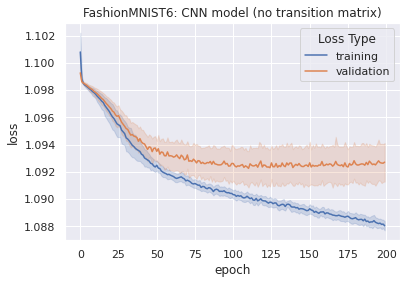

In [ ]:
df_all = pd.DataFrame()

for j in range(10):

    df = pd.DataFrame(training_losses_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'loss'}, inplace=True)
    df['Loss Type'] = 'training'

    df_all = pd.concat([df_all, df])

for j in range(10):

    df = pd.DataFrame(validation_losses_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'loss'}, inplace=True)
    df['Loss Type'] = 'validation'

    df_all = pd.concat([df_all, df])

sns.lineplot(data=df_all, x='epoch', y='loss', hue='Loss Type')
plt.title('FashionMNIST6: CNN model (no transition matrix)')
plt.savefig('Figures/FashionMNIST6_CNN_no_T_loss.png', dpi=300)
plt.show()

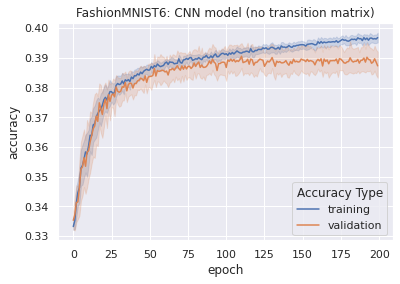

In [ ]:
df_all = pd.DataFrame()

for j in range(10):

    df = pd.DataFrame(training_accuracies_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'accuracy'}, inplace=True)
    df['Accuracy Type'] = 'training'

    df_all = pd.concat([df_all, df])

for j in range(10):

    df = pd.DataFrame(validation_accuracies_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'accuracy'}, inplace=True)
    df['Accuracy Type'] = 'validation'

    df_all = pd.concat([df_all, df])

sns.lineplot(data=df_all, x='epoch', y='accuracy', hue='Accuracy Type')
plt.title('FashionMNIST6: CNN model (no transition matrix)')
plt.savefig('Figures/FashionMNIST6_CNN_no_T_accuracy.png', dpi=300)
plt.show()

In [ ]:
deltas_all = []
t_matrices_all = []

for run in range(10):

    print(run)

    run_configuration['seed'] = 42 + run
    run_configuration['run'] = run

    # set random seed
    seed_torch(run_configuration['seed'])

    # set up dataloaders
    training_dataloader, validation_dataloader, test_dataloader = get_loader(data_path=data_configuration['data_path'], 
                                                                                                                                                     training_pct=data_configuration['training_pct'], 
                                                                                                                                                     batch_size=data_configuration['batch_size'], 
                                                                                                                                                     num_workers=data_configuration['num_workers'])

    deltas = []
    t_matrices = []

    for epoch in range(optimizer_configuration['epochs']):

        model_class = globals()[model_configuration['model_name']]
        model = model_class(*model_configuration['params'])

        outdir = run_configuration['outdir']
        a = model_configuration['model_name']
        b = run_configuration['run']
        model_path = os.path.join(outdir, f'{a}_{b}_{epoch}.pth')
        model.load_state_dict(torch.load(model_path)['model_state_dict'])
    
        if torch.cuda.device_count() > 1:
            print(torch.cuda.device_count(), "GPUs are used!")
            model = nn.DataParallel(model)
        model.to(device)

        model.eval()

        all_probabilities = []

        for features, labels in training_dataloader:
                
            features = features.to(device)
            labels = labels.numpy()

            with torch.no_grad():
                log_probabilities = model(features)

            probabilities = torch.exp(log_probabilities) #.cpu().data.numpy()
            all_probabilities.append(probabilities)

        all_probabilities = torch.vstack(all_probabilities)

        transition_matrix = []

        for index in range(all_probabilities.size(1)):

            transition_matrix.append(torch.mean(all_probabilities[torch.topk(all_probabilities[:, index], 10).indices], dim=0).cpu().numpy())

        transition_matrix = np.vstack(transition_matrix).T
        t_matrices.append(transition_matrix)

        given_transition_matrix = np.array([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]])

        delta = np.linalg.norm(transition_matrix - given_transition_matrix)
        deltas.append(delta)

    t_matrices_all.append(t_matrices)
    deltas_all.append(deltas)

0
1
2
3
4
5
6
7
8
9


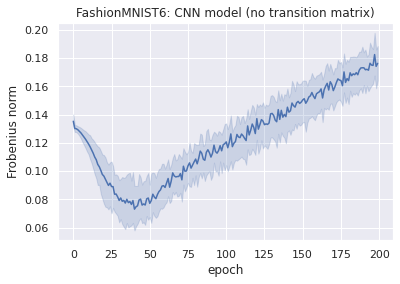

In [ ]:
df_all = pd.DataFrame()

for j in range(10):

    df = pd.DataFrame(deltas_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'Frobenius norm'}, inplace=True)

    df_all = pd.concat([df_all, df])

sns.lineplot(data=df_all, x='epoch', y='Frobenius norm')
plt.title('FashionMNIST6: CNN model (no transition matrix)')
plt.savefig('Figures/FashionMNIST6_CNN_no_T_frobenius.png', dpi=300)
plt.show()

In [ ]:
t_matrix = []

for j in range(10):

    t_matrix.append(t_matrices_all[j][60])

t_matrix = np.stack(t_matrix)

print(np.round(np.mean(t_matrix, axis=0), 2))
print(np.round(np.std(t_matrix, axis=0), 2))

[[0.44 0.29 0.3 ]
 [0.27 0.44 0.28]
 [0.29 0.27 0.42]]
[[0.01 0.01 0.02]
 [0.01 0.01 0.03]
 [0.01 0.02 0.02]]


In [ ]:
run_configuration = {}
run_configuration['seed'] = 42
run_configuration['run'] = 0
run_configuration['outdir'] = './MNIST6_T_CNN'

data_configuration = {}
data_configuration['data_path'] = '../datasets/FashionMNIST0.6.npz'
data_configuration['training_pct'] = 0.8
data_configuration['batch_size'] = [720, 100, 100]
data_configuration['num_workers'] = 1

model_configuration = {}
model_configuration['model_name'] = 'CNNmodel'
model_configuration['params'] = [1, 160, 22, 3, torch.Tensor([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]])]

optimizer_configuration = {}
optimizer_configuration['lr'] = 0.01
optimizer_configuration['momentum'] = 0.9
optimizer_configuration['weight_decay'] = 1e-5
optimizer_configuration['epochs'] = 400

configuration = {}
configuration['run'] = run_configuration
configuration['data'] = data_configuration
configuration['model'] = model_configuration
configuration['optimizer'] = optimizer_configuration

In [ ]:
training_losses_all = []
training_accuracies_all = [] 
validation_losses_all = [] 
validation_accuracies_all = []

for run in range(10):

    print(run)

    run_configuration['seed'] = 42 + run
    run_configuration['run'] = run

    training_losses, training_accuracies, validation_losses, validation_accuracies = run_train(configuration, device)

    training_losses_all.append(training_losses)
    training_accuracies_all.append(training_accuracies) 
    validation_losses_all.append(validation_losses)
    validation_accuracies_all.append(validation_accuracies)

0
1
2


KeyboardInterrupt: ignored

In [ ]:
test_losses_all = []
test_accuracies_all = []

for run in range(10):

    print(run)

    run_configuration['seed'] = 42 + run
    run_configuration['run'] = run

    # set random seed
    seed_torch(run_configuration['seed'])

    # set up dataloaders
    training_dataloader, validation_dataloader, test_dataloader = get_loader(data_path=data_configuration['data_path'], 
                                                                                                                                                     training_pct=data_configuration['training_pct'], 
                                                                                                                                                     batch_size=data_configuration['batch_size'], 
                                                                                                                                                     num_workers=data_configuration['num_workers'])
    
    # criterion and optimizer
    criterion = torch.nn.NLLLoss()

    test_losses = []
    test_accuracies = []

    for epoch in range(optimizer_configuration['epochs']):

        model_class = globals()[model_configuration['model_name']]
        model = model_class(*model_configuration['params'])

        outdir = run_configuration['outdir']
        a = model_configuration['model_name']
        b = run_configuration['run']
        model_path = os.path.join(outdir, f'{a}_{b}_{epoch}.pth')
        model.load_state_dict(torch.load(model_path)['model_state_dict'])
    
        if torch.cuda.device_count() > 1:
            print(torch.cuda.device_count(), "GPUs are used!")
            model = nn.DataParallel(model)
        model.to(device)

        # test
        test_loss, test_accuracy = validate_test(model, criterion, test_dataloader, device)

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    test_losses_all.append(test_losses)
    test_accuracies_all.append(test_accuracies)        

0
1
2
3
4
5
6
7
8
9


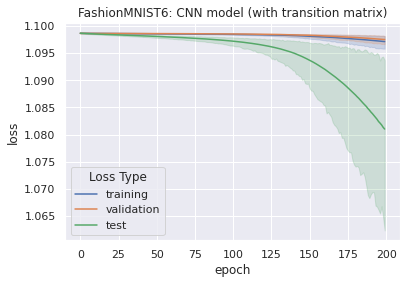

In [ ]:
df_all = pd.DataFrame()

for j in range(10):

    df = pd.DataFrame(training_losses_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'loss'}, inplace=True)
    df['Loss Type'] = 'training'

    df_all = pd.concat([df_all, df])

for j in range(10):

    df = pd.DataFrame(validation_losses_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'loss'}, inplace=True)
    df['Loss Type'] = 'validation'

    df_all = pd.concat([df_all, df])

for j in range(10):

    df = pd.DataFrame(test_losses_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'loss'}, inplace=True)
    df['Loss Type'] = 'test'

    df_all = pd.concat([df_all, df])

sns.lineplot(data=df_all, x='epoch', y='loss', hue='Loss Type')
plt.title('FashionMNIST6: CNN model (with transition matrix)')
plt.savefig('Figures/FashionMNIST6_CNN_with_T_loss.png', dpi=300)
plt.show()

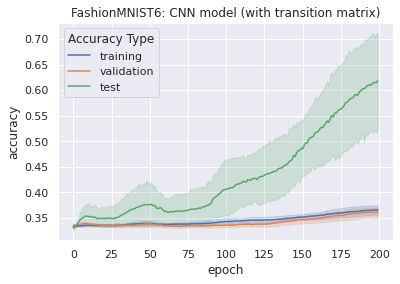

In [ ]:
df_all = pd.DataFrame()

for j in range(10):

    df = pd.DataFrame(training_accuracies_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'accuracy'}, inplace=True)
    df['Accuracy Type'] = 'training'

    df_all = pd.concat([df_all, df])

for j in range(10):

    df = pd.DataFrame(validation_accuracies_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'accuracy'}, inplace=True)
    df['Accuracy Type'] = 'validation'

    df_all = pd.concat([df_all, df])

for j in range(10):

    df = pd.DataFrame(test_accuracies_all[j])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'epoch', 0: 'accuracy'}, inplace=True)
    df['Accuracy Type'] = 'test'

    df_all = pd.concat([df_all, df])

sns.lineplot(data=df_all, x='epoch', y='accuracy', hue='Accuracy Type')
plt.title('FashionMNIST6: CNN model (with transition matrix)')
plt.savefig('Figures/FashionMNIST6_CNN_with_T_accuracy.png', dpi=300)
plt.show()